# INFO 3401 – Class 20: Forecasting with simple regression

[Brian C. Keegan, Ph.D.](http://brianckeegan.com/)  
[Assistant Professor, Department of Information Science](https://www.colorado.edu/cmci/people/information-science/brian-c-keegan)  
University of Colorado Boulder  

Copyright and distributed under an [MIT License](https://opensource.org/licenses/MIT).

## Learning Objectives
This lecture will introduce forecasting, one of the most common data analysis tasks when working with time series data.

* Review content about temporal structure, additive models, and autocorrelation
* Using the `statsmodels` and `prophet` libraries to forecast temporal data
* Making and interpreting forecasts using DIA, BEST, and other time series data

## Background

This lecture will introduce linear regression as a method for time series forecasting and statsmodels as a library for making and interpreting regression models.

## Load libraries

In [1]:
import pandas as pd
import numpy as np

pd.options.display.max_columns = 100

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb

## Installing/updating two new libraries

### `statsmodels`

This should come with Anaconda by default, but run these commands in your Terminal just to be sure.

`conda update --all`  
`conda install -c anaconda statsmodels`  

Import the statsmodels library.

In [2]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

## Load data

In [3]:
# Read in the data
den_pass_df = pd.read_csv('den_passengers.csv',index_col=0)

# Cast the index to periods
den_pass_df.index = pd.period_range(den_pass_df.index[0],den_pass_df.index[-1],freq='M')

# Park the original columns
orig_cols = den_pass_df.columns

# Inspect
print(den_pass_df.shape)
den_pass_df.tail(10)

(307, 7)


,American,Delta,Frontier,Other,Southwest,United Express,United
2019-11,248838,271136,645543,269124,1502102.0,653590,1713647
2019-12,285504,312654,558746,306029,1661202.0,749165,1915520
2020-01,252609,277318,527185,282431,1407678.0,685777,1765230
2020-02,236439,263292,493984,258516,1306590.0,694512,1655042
2020-03,146987,150119,306420,147830,770226.0,438251,963524
2020-04,25272,14773,29753,8748,89035.0,41679,89838
2020-05,48289,28214,144702,14486,320493.0,120265,158422
2020-06,74928,48656,323277,45765,809923.0,197807,250012
2020-07,154607,81130,479485,148904,945160.0,294247,488744
2020-08,171353,105907,533026,136293,951646.0,339484,747851


## Exploring, viusualizing, and feature engineering
Engineer some new features.

In [4]:
den_pass_df['Total'] = den_pass_df[orig_cols].sum(1)
den_pass_df['Rolling Total'] = den_pass_df['Total'].rolling(12).mean()

# Inspect
den_pass_df.tail()

,American,Delta,Frontier,Other,Southwest,United Express,United,Total,Rolling Total
2020-04,25272,14773,29753,8748,89035.0,41679,89838,299098.0,5.172371e+06
2020-05,48289,28214,144702,14486,320493.0,120265,158422,834871.0,4.738468e+06
2020-06,74928,48656,323277,45765,809923.0,197807,250012,1750368.0,4.352193e+06
2020-07,154607,81130,479485,148904,945160.0,294247,488744,2592277.0,4.007159e+06
2020-08,171353,105907,533026,136293,951646.0,339484,747851,2985560.0,3.718033e+06


Visualize the data as a baseline.

Text(2020-01, 500000.0, 'COVID-19 shutdowns')

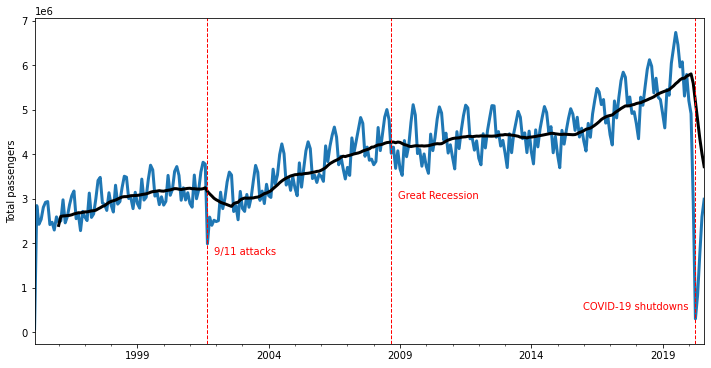

In [5]:
f,ax = plt.subplots(figsize=(12,6))
den_pass_df['Total'].plot(lw=3,ax=ax)
den_pass_df['Rolling Total'].plot(lw=3,ax=ax,c='k')

ax.set_ylabel('Total passengers')

# Annotate
ax.axvline(pd.Period('2001-09'),c='r',ls='--',lw=1)
ax.text(pd.Period('2001-09')+3,1.75e6,'9/11 attacks',c='r')

ax.axvline(pd.Period('2008-09'),c='r',ls='--',lw=1)
ax.text(pd.Period('2008-09')+3,3e6,'Great Recession',c='r')

ax.axvline(pd.Period('2020-04'),c='r',ls='--',lw=1)
ax.text(pd.Period('2020-04')-3,5e5,'COVID-19 shutdowns',c='r',ha='right')

# f.savefig('den_passengers.png',dpi=300)

## Forecasting with simple regression (pre-class)

Linear regression is an essential part of every data scientist's toolkit. At its heart, it allows us to model, predict, and explain the relationship between a continuous outcome variable and one or more predictor variables. There are many important limitations and biases when using linear regression to be aware of as well, so it is not the solution to every data modeling problem. We will spend more time going into this method, so let's start with an example using our case of the DEN passenger data.

Our goal is to predict the number of passengers for any given month by the number of passengers in previous months. In the simplest possible model we can specify, the outcome variable is the number of passengers and our predictor variable is the number of months the airport has been open. As the rolling average trend above captures, a younger DEN airport should have fewer passengers and an older DEN airport should have more passengers.

Linear regression wants continuous variables for both its predictors and outcome variables. Our outcome variable "Total passengers" is already continuous. We want to model time as a continuous variable, but the `Period` objects we've used for the index aren't really continuous.

First make a new column "months_open" with the number of 30-day months since the airport opened. We can use the `.to_timestamp()` method on the index to turn it into `Timestamp` objects. Subtracting from a fixed opening date like February 1, 1995 will return `Timedelta` objects. Dividing a `Timedelta` object by another `Timedelta` object will return a simple continuous float we can use as a predictor in the regression.

In [6]:
den_pass_df.head()

,American,Delta,Frontier,Other,Southwest,United Express,United,Total,Rolling Total
1995-02,5833,4805,1434,8625,NaN,2635,47230,70562.0,NaN
1995-03,228196,200964,36703,245171,NaN,169190,1962445,2842669.0,NaN
1995-04,184229,157853,40050,191393,NaN,124351,1724836,2422712.0,NaN
1995-05,187990,162622,41403,171425,NaN,135800,1833305,2532545.0,NaN
1995-06,229348,198499,43754,186030,NaN,170033,1975754,2803418.0,NaN


In [7]:
den_pass_df['months_open'] = (den_pass_df.index.to_timestamp() - pd.Timestamp('1995-02-01'))/pd.Timedelta(30,'D')
den_pass_df.head()

,American,Delta,Frontier,Other,Southwest,United Express,United,Total,Rolling Total,months_open
1995-02,5833,4805,1434,8625,NaN,2635,47230,70562.0,NaN,0.000000
1995-03,228196,200964,36703,245171,NaN,169190,1962445,2842669.0,NaN,0.933333
1995-04,184229,157853,40050,191393,NaN,124351,1724836,2422712.0,NaN,1.966667
1995-05,187990,162622,41403,171425,NaN,135800,1833305,2532545.0,NaN,2.966667
1995-06,229348,198499,43754,186030,NaN,170033,1975754,2803418.0,NaN,4.000000


Second, use seaborn's [`lmplot`](https://seaborn.pydata.org/generated/seaborn.lmplot.html) to visualize the kind of linear relationship between the "months_open" variable on the x-axis and the "Total passengers" on the y-axis.

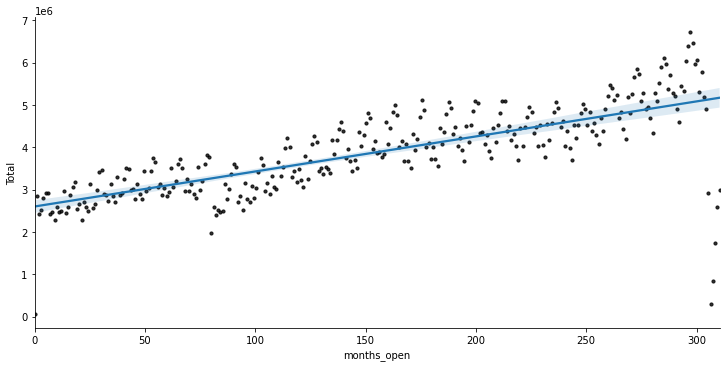

In [8]:
g = sb.lmplot(x='months_open',
          y='Total',
          data=den_pass_df,
          aspect=2,
          scatter_kws={'color':'k','s':10})

Third, use statsmodel's [formula functionality](https://www.statsmodels.org/dev/example_formulas.html) to specify and estimate a simple regression model.

In [9]:
den_pass_df.tail()

,American,Delta,Frontier,Other,Southwest,United Express,United,Total,Rolling Total,months_open
2020-04,25272,14773,29753,8748,89035.0,41679,89838,299098.0,5.172371e+06,306.366667
2020-05,48289,28214,144702,14486,320493.0,120265,158422,834871.0,4.738468e+06,307.366667
2020-06,74928,48656,323277,45765,809923.0,197807,250012,1750368.0,4.352193e+06,308.400000
2020-07,154607,81130,479485,148904,945160.0,294247,488744,2592277.0,4.007159e+06,309.400000
2020-08,171353,105907,533026,136293,951646.0,339484,747851,2985560.0,3.718033e+06,310.433333


In [10]:
m0 = smf.ols('Total ~ months_open',data=den_pass_df).fit()
m0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Total   R-squared:                       0.549
Model:                            OLS   Adj. R-squared:                  0.547
Method:                 Least Squares   F-statistic:                     371.2
Date:                Wed, 07 Oct 2020   Prob (F-statistic):           1.13e-54
Time:                        10:18:10   Log-Likelihood:                -4555.9
No. Observations:                 307   AIC:                             9116.
Df Residuals:                     305   BIC:                             9123.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    2.603e+06    7.7e+04     33.810      0.000    2.45e+06    2.75e+06
months_open  8271.8396    429.320     19.267      0.000    7427.035    9116.644
==============================================================================
Omnibus:                      224.551   Durbin-Watson:                   0.489
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3676.522
Skew:                          -2.807   Prob(JB):                         0.00
Kurtosis:                      18.997   Cond. No.                         358.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Fourth, interpret the parameters and performance of this regression model.

Fifth, use the [`wls_prediction_std`](https://www.statsmodels.org/dev/examples/notebooks/generated/ols.html#OLS-non-linear-curve-but-linear-in-parameters) function to extract the model predictions and errors overlay on top of the observed data.  Interpret the predictions from the model against the actual data. What does the model do well? Poorly? Unexpectedly?

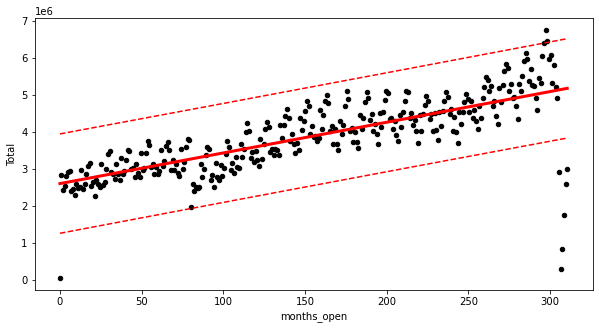

In [11]:
from statsmodels.sandbox.regression.predstd import wls_prediction_std

pred,iv_l,iv_u = wls_prediction_std(m0)

f,ax = plt.subplots(figsize=(10,5))

den_pass_df.plot.scatter(x='months_open',y='Total',ax=ax,c='k')
ax.plot(den_pass_df['months_open'],m0.fittedvalues,c='r',lw=3)
ax.plot(den_pass_df['months_open'],iv_l,c='r',ls='--')
ax.plot(den_pass_df['months_open'],iv_u,c='r',ls='--')

Sixth, make a new DataFrame that goes a few years into the future. Use the `.predict()` method on the fitted model from Step 3 with the extended "months_open" variable to forecast the future number of passengers.

In [12]:
future_pass_s = pd.Series(index=pd.period_range('2020-09','2024-12',freq='M'),data=np.nan)

future_months = (future_pass_s.index.to_timestamp() - pd.Timestamp('1995-02-01'))/pd.Timedelta(30,'D')
predict_pass_df = pd.DataFrame(data = {'months_open':future_months},
                               index = future_pass_s.index)

predict_pass_df.head()

,months_open
2020-09,311.466667
2020-10,312.466667
2020-11,313.500000
2020-12,314.500000
2021-01,315.533333


In [13]:
den_pass_df['m0'] = m0.predict({'months_open':den_pass_df['months_open']})
den_pass_df.tail(10)

,American,Delta,Frontier,Other,Southwest,United Express,United,Total,Rolling Total,months_open,m0
2019-11,248838,271136,645543,269124,1502102.0,653590,1713647,5303980.0,5.704145e+06,301.300000,5.095752e+06
2019-12,285504,312654,558746,306029,1661202.0,749165,1915520,5788820.0,5.751247e+06,302.300000,5.104023e+06
2020-01,252609,277318,527185,282431,1407678.0,685777,1765230,5198228.0,5.774883e+06,303.333333,5.112571e+06
2020-02,236439,263292,493984,258516,1306590.0,694512,1655042,4908375.0,5.801548e+06,304.366667,5.121119e+06
2020-03,146987,150119,306420,147830,770226.0,438251,963524,2923357.0,5.590893e+06,305.333333,5.129115e+06
2020-04,25272,14773,29753,8748,89035.0,41679,89838,299098.0,5.172371e+06,306.366667,5.137662e+06
2020-05,48289,28214,144702,14486,320493.0,120265,158422,834871.0,4.738468e+06,307.366667,5.145934e+06
2020-06,74928,48656,323277,45765,809923.0,197807,250012,1750368.0,4.352193e+06,308.400000,5.154482e+06
2020-07,154607,81130,479485,148904,945160.0,294247,488744,2592277.0,4.007159e+06,309.400000,5.162753e+06
2020-08,171353,105907,533026,136293,951646.0,339484,747851,2985560.0,3.718033e+06,310.433333,5.171301e+06


In [14]:
predict_pass_df['m0'] = m0.predict({'months_open':predict_pass_df['months_open']})
predict_pass_df.head()

,months_open,m0
2020-09,311.466667,5.179849e+06
2020-10,312.466667,5.188120e+06
2020-11,313.500000,5.196668e+06
2020-12,314.500000,5.204940e+06
2021-01,315.533333,5.213487e+06


Seventh, visualize the model predictions going into the future.

<AxesSubplot:xlabel='months_open', ylabel='Total'>

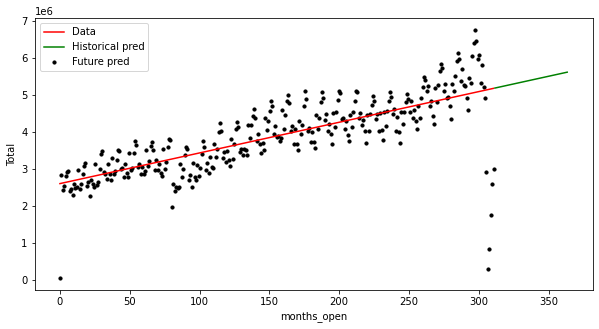

In [15]:
f, ax = plt.subplots(figsize=(10,5))

den_pass_df.plot.scatter(x='months_open',y='Total',c='k',s=10,label='Data',ax=ax)
den_pass_df.plot.line(x='months_open',y='m0',c='r',label='Historical pred',ax=ax)
predict_pass_df.plot.line(x='months_open',y='m0',c='g',label='Future pred',ax=ax)

## Forecasting with fixed effects (in-class)

We know there is a strong monthly pattern to the data: passenger numbers are higher in the summer, lower in the winter, *etc*. The way we've specified our regression model only allows for the number of months since the airport opened, but doesn't carry any of these monthly patterns. We can used "fixed effects" with the months to capture this behavior in the data.

First, make a new column "months" and extract the month from the index.

In [38]:
den_pass_df['months_open'] = (den_pass_df.index.to_timestamp() - pd.Timestamp('1995-02-01'))/pd.Timedelta(30,'D')

In [39]:
den_pass_df['months'] = [i.month for i in den_pass_df.index]
den_pass_df.tail(10)

,American,Delta,Frontier,Other,Southwest,United Express,United,Total,Rolling Total,months_open,m0,months
2019-11,248838,271136,645543,269124,1502102.0,653590,1713647,5303980.0,5.704145e+06,301.300000,5.095752e+06,11
2019-12,285504,312654,558746,306029,1661202.0,749165,1915520,5788820.0,5.751247e+06,302.300000,5.104023e+06,12
2020-01,252609,277318,527185,282431,1407678.0,685777,1765230,5198228.0,5.774883e+06,303.333333,5.112571e+06,1
2020-02,236439,263292,493984,258516,1306590.0,694512,1655042,4908375.0,5.801548e+06,304.366667,5.121119e+06,2
2020-03,146987,150119,306420,147830,770226.0,438251,963524,2923357.0,5.590893e+06,305.333333,5.129115e+06,3
2020-04,25272,14773,29753,8748,89035.0,41679,89838,299098.0,5.172371e+06,306.366667,5.137662e+06,4
2020-05,48289,28214,144702,14486,320493.0,120265,158422,834871.0,4.738468e+06,307.366667,5.145934e+06,5
2020-06,74928,48656,323277,45765,809923.0,197807,250012,1750368.0,4.352193e+06,308.400000,5.154482e+06,6
2020-07,154607,81130,479485,148904,945160.0,294247,488744,2592277.0,4.007159e+06,309.400000,5.162753e+06,7
2020-08,171353,105907,533026,136293,951646.0,339484,747851,2985560.0,3.718033e+06,310.433333,5.171301e+06,8


Second, use statesmodel's formula functionality to specify and estimate a fixed effects regression model.

In [24]:
m0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Total   R-squared:                       0.549
Model:                            OLS   Adj. R-squared:                  0.547
Method:                 Least Squares   F-statistic:                     371.2
Date:                Wed, 07 Oct 2020   Prob (F-statistic):           1.13e-54
Time:                        10:34:22   Log-Likelihood:                -4555.9
No. Observations:                 307   AIC:                             9116.
Df Residuals:                     305   BIC:                             9123.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    2.603e+06    7.7e+04     33.810      0.000    2.45e+06    2.75e+06
months_open  8271.8396    429.320     19.267      0.000    7427.035    9116.644
==============================================================================
Omnibus:                      224.551   Durbin-Watson:                   0.489
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3676.522
Skew:                          -2.807   Prob(JB):                         0.00
Kurtosis:                      18.997   Cond. No.                         358.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<AxesSubplot:xlabel='months', ylabel='Total'>

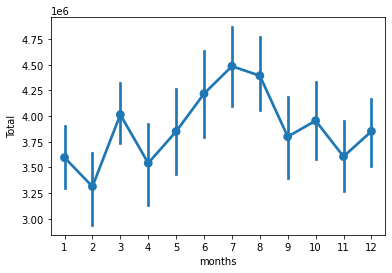

In [20]:
sb.pointplot(x='months',y='Total',data=den_pass_df)

In [22]:
m1 = smf.ols('Total ~ months_open + C(months)',data=den_pass_df).fit()
m1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Total   R-squared:                       0.657
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     47.01
Date:                Wed, 07 Oct 2020   Prob (F-statistic):           3.28e-61
Time:                        10:34:13   Log-Likelihood:                -4513.7
No. Observations:                 307   AIC:                             9053.
Df Residuals:                     294   BIC:                             9102.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        2.301e+06   1.34e+05     17.147      0.000    2.04e+06    2.57e+06
C(months)[T.2]  -2.401e+05   1.68e+05     -1.428      0.154   -5.71e+05    9.09e+04
C(months)[T.3]   4.524e+05   1.68e+05      2.690      0.008    1.21e+05    7.83e+05
C(months)[T.4]  -2.836e+04   1.68e+05     -0.169      0.866   -3.59e+05    3.03e+05
C(months)[T.5]   2.715e+05   1.68e+05      1.614      0.108   -5.95e+04    6.02e+05
C(months)[T.6]    6.31e+05   1.68e+05      3.752      0.000       3e+05    9.62e+05
C(months)[T.7]   8.902e+05   1.68e+05      5.293      0.000    5.59e+05    1.22e+06
C(months)[T.8]   7.895e+05   1.68e+05      4.694      0.000    4.58e+05    1.12e+06
C(months)[T.9]   2.377e+05    1.7e+05      1.399      0.163   -9.66e+04    5.72e+05
C(months)[T.10]  3.843e+05    1.7e+05      2.263      0.024       5e+04    7.19e+05
C(months)[T.11]  2.716e+04    1.7e+05      0.160      0.873   -3.07e+05    3.61e+05
C(months)[T.12]  2.646e+05    1.7e+05      1.558      0.120   -6.96e+04    5.99e+05
months_open      8229.3281    381.197     21.588      0.000    7479.107    8979.549
==============================================================================
Omnibus:                      323.874   Durbin-Watson:                   0.228
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11154.295
Skew:                          -4.557   Prob(JB):                         0.00
Kurtosis:                      31.088   Cond. No.                     2.26e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.26e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Third, interpret the parameters and performance of this regression model.

Fourth, make a new DataFrame that goes a few years into the future. Use the `.predict()` method on the fitted model from Step 2 with the extended "months_open" variable to forecast the future number of passengers.

In [42]:
den_pass_df['m1'] = m1.predict({'months_open':den_pass_df['months_open'],
                                'months':den_pass_df['months']
                               })

den_pass_df.tail(10)

,American,Delta,Frontier,Other,Southwest,United Express,United,Total,Rolling Total,months_open,m0,months,m1
2019-11,248838,271136,645543,269124,1502102.0,653590,1713647,5303980.0,5.704145e+06,301.300000,5.095752e+06,11,4.808029e+06
2019-12,285504,312654,558746,306029,1661202.0,749165,1915520,5788820.0,5.751247e+06,302.300000,5.104023e+06,12,5.053735e+06
2020-01,252609,277318,527185,282431,1407678.0,685777,1765230,5198228.0,5.774883e+06,303.333333,5.112571e+06,1,4.797605e+06
2020-02,236439,263292,493984,258516,1306590.0,694512,1655042,4908375.0,5.801548e+06,304.366667,5.121119e+06,2,4.565986e+06
2020-03,146987,150119,306420,147830,770226.0,438251,963524,2923357.0,5.590893e+06,305.333333,5.129115e+06,3,5.266435e+06
2020-04,25272,14773,29753,8748,89035.0,41679,89838,299098.0,5.172371e+06,306.366667,5.137662e+06,4,4.794210e+06
2020-05,48289,28214,144702,14486,320493.0,120265,158422,834871.0,4.738468e+06,307.366667,5.145934e+06,5,5.102281e+06
2020-06,74928,48656,323277,45765,809923.0,197807,250012,1750368.0,4.352193e+06,308.400000,5.154482e+06,6,5.470340e+06
2020-07,154607,81130,479485,148904,945160.0,294247,488744,2592277.0,4.007159e+06,309.400000,5.162753e+06,7,5.737708e+06
2020-08,171353,105907,533026,136293,951646.0,339484,747851,2985560.0,3.718033e+06,310.433333,5.171301e+06,8,5.645503e+06


Fifth, visualize the model predictions going into the future.

<AxesSubplot:xlabel='months_open', ylabel='Total'>

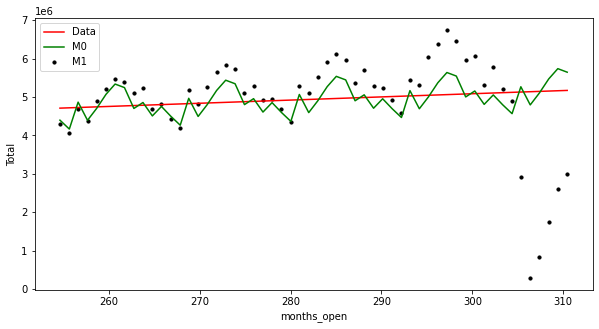

In [60]:
f,ax = plt.subplots(figsize=(10,5))

den_pass_df.loc['2016-01':].plot.scatter(x='months_open',y='Total',c='k',s=10,label='Data',ax=ax)

den_pass_df.loc['2016-01':].plot.line(x='months_open',y='m0',c='r',label='M0',ax=ax)

den_pass_df.loc['2016-01':].plot.line(x='months_open',y='m1',c='g',label='M1',ax=ax)

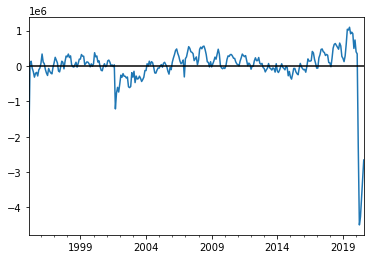

In [59]:
ax = m1.resid.plot()

ax.axhline(0,c='k')

Now make some forecasts.

In [65]:
predict_pass_df['months'] = [i.month for i in predict_pass_df.index]

predict_pass_df.head()

,months_open,m0,months
2020-09,311.466667,5.179849e+06,9
2020-10,312.466667,5.188120e+06,10
2020-11,313.500000,5.196668e+06,11
2020-12,314.500000,5.204940e+06,12
2021-01,315.533333,5.213487e+06,1


In [67]:
predict_pass_df['m1'] = m1.predict({'months_open':predict_pass_df['months_open'],
                                    'months':predict_pass_df['months']
                                   })

predict_pass_df.head()

,months_open,m0,months,m1
2020-09,311.466667,5.179849e+06,9,5.102205e+06
2020-10,312.466667,5.188120e+06,10,5.257048e+06
2020-11,313.500000,5.196668e+06,11,4.908426e+06
2020-12,314.500000,5.204940e+06,12,5.154133e+06
2021-01,315.533333,5.213487e+06,1,4.898003e+06


<AxesSubplot:xlabel='months_open', ylabel='Total'>

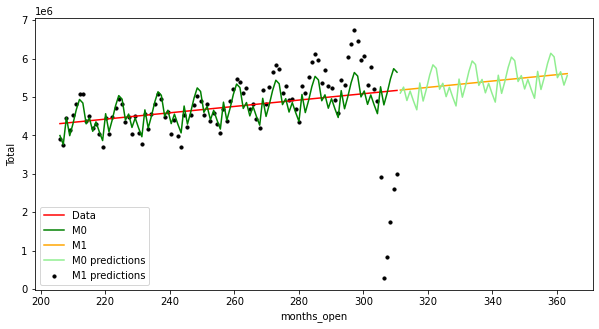

In [72]:
f,ax = plt.subplots(figsize=(10,5))

# Original data
den_pass_df.loc['2012-01':].plot.scatter(x='months_open',y='Total',c='k',s=10,label='Data',ax=ax)

# Models looking back in time
den_pass_df.loc['2012-01':].plot.line(x='months_open',y='m0',c='r',label='M0',ax=ax)
den_pass_df.loc['2012-01':].plot.line(x='months_open',y='m1',c='g',label='M1',ax=ax)

# Models looking forward in time
predict_pass_df.plot.line(x='months_open',y='m0',c='orange',label='M0 predictions',ax=ax)
predict_pass_df.plot.line(x='months_open',y='m1',c='lightgreen',label='M1 predictions',ax=ax)

## Exercise: Forecasting with BEST data

First: Read in the BEST temperature data, cast the months column to a `Timestamp` or `Period` object, set as an index, and describe the data.

In [73]:
best_df = pd.read_csv('berkeley_temps.csv')
best_df.head()

,Date,1M Anomaly,1M Uncertainty,1Y Anomaly,1Y Uncertainty,5Y Anomaly,5Y Uncertainty,10Y Anomaly,10Y Uncertainty,20Y Anomaly,20Y Uncertainty
0,1750-01,-0.652,3.925,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1750-02,-1.223,4.059,-1.052,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1750-03,0.065,3.250,-1.078,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1750-04,-0.399,2.059,-1.108,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1750-05,-1.838,3.638,-1.420,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Second: Make a plot of the 1M anomaly data (ideally really wide).

Third: make a new column "elapsed" that (similar to the "months_open" variable from above) where the values are `float`s of the number of days since January 1750.

Fourth: use statsmodel's formula functionality to specify an estimate a simple regression model using the "elapsed" as a predictor and the "1M anomaly" as an outcome variable. Alternatively, estimate a more advanced regression model that includes fixed effects on the month.

Fifth: interpret the estimated parameters and performance of this regression model.

Sixth: make a new DataFrame that goes a few years/decades into the future. Use the `.predict()` method on the fitted model from step 4 with the extended dates to forecast the future temperatures.

Seventh: visualize the model predictions going into the future.